The purpose of this notebook is to detail the bike ride data from the Google Data Analytics course. The goal of the analysis was to asses how different users (member or casual) use the bike ride service and what, if any, recommendations there might be to convert casual users to members.

In [ ]:
library(tidyverse)  #helps wrangle data
# Use the conflicted package to manage conflicts
library(conflicted)

# Set dplyr::filter and dplyr::lag as the default choices
conflict_prefer("filter", "dplyr")
conflict_prefer("lag", "dplyr")

#=====================
# STEP 1: COLLECT DATA
#=====================
# # Upload Divvy datasets (csv files) here
q1_2019 <- read_csv("Divvy_Trips_2019_Q1.csv")
q1_2020 <- read_csv("Divvy_Trips_2020_Q1.csv")


#====================================================
# STEP 2: WRANGLE DATA AND COMBINE INTO A SINGLE FILE
#====================================================
# Compare column names each of the files
# While the names don't have to be in the same order, they DO need to match perfectly before we can use a command to join them into one file
colnames(q1_2019)
colnames(q1_2020)

# Rename columns  to make them consistent with q1_2020 (as this will be the supposed going-forward table design for Divvy)

(q1_2019 <- rename(q1_2019
                   ,ride_id = trip_id
                   ,rideable_type = bikeid
                   ,started_at = start_time
                   ,ended_at = end_time
                   ,start_station_name = from_station_name
                   ,start_station_id = from_station_id
                   ,end_station_name = to_station_name
                   ,end_station_id = to_station_id
                   ,member_casual = usertype
                   ))

# Inspect the dataframes and look for incongruencies
str(q1_2019)
str(q1_2020)

# Convert ride_id and rideable_type to character so that they can stack correctly
q1_2019 <-  mutate(q1_2019, ride_id = as.character(ride_id)
                   ,rideable_type = as.character(rideable_type)) 

# Stack individual quarter's data frames into one big data frame
all_trips <- bind_rows(q1_2019, q1_2020)#, q3_2019)#, q4_2019, q1_2020)

# Remove lat, long, birthyear, and gender fields as this data was dropped beginning in 2020
all_trips <- all_trips %>%  
  select(-c(start_lat, start_lng, end_lat, end_lng, birthyear, gender,  "tripduration"))

#======================================================
# STEP 3: CLEAN UP AND ADD DATA TO PREPARE FOR ANALYSIS
#======================================================
# Inspect the new table that has been created
colnames(all_trips)  #List of column names
nrow(all_trips)  #How many rows are in data frame?
dim(all_trips)  #Dimensions of the data frame?
head(all_trips)  #See the first 6 rows of data frame.  Also tail(all_trips)
str(all_trips)  #See list of columns and data types (numeric, character, etc)
summary(all_trips)  #Statistical summary of data. Mainly for numerics

# There are a few problems we will need to fix:
# (1) In the "member_casual" column, there are two names for members ("member" and "Subscriber") and two names for casual riders ("Customer" and "casual"). We will need to consolidate that from four to two labels.
# (1.1) Added a line of code to check for unique values in this column to verify
unique_values <- unique(all_trips$member_casual)
print(unique_values)

# (2) The data can only be aggregated at the ride-level, which is too granular. We will want to add some additional columns of data -- such as day, month, year -- that provide additional opportunities to aggregate the data.
# (3) We will want to add a calculated field for length of ride since the 2020Q1 data did not have the "tripduration" column. We will add "ride_length" to the entire dataframe for consistency.
# (4) There are some rides where tripduration shows up as negative, including several hundred rides where Divvy took bikes out of circulation for Quality Control reasons. We will want to delete these rides.

# In the "member_casual" column, replace "Subscriber" with "member" and "Customer" with "casual"
# Before 2020, Divvy used different labels for these two types of riders ... we will want to make our dataframe consistent with their current nomenclature
# N.B.: "Level" is a special property of a column that is retained even if a subset does not contain any values from a specific level
# Begin by seeing how many observations fall under each usertype
table(all_trips$member_casual)

# Reassign to the desired values (we will go with the current 2020 labels)
all_trips <-  all_trips %>% 
  mutate(member_casual = recode(member_casual
                                ,"Subscriber" = "member"
                                ,"Customer" = "casual"))

# Check to make sure the proper number of observations were reassigned
table(all_trips$member_casual)

# Add columns that list the date, month, day, and year of each ride
# This will allow us to aggregate ride data for each month, day, or year ... before completing these operations we could only aggregate at the ride level
# https://www.statmethods.net/input/dates.html more on date formats in R found at that link
all_trips$date <- as.Date(all_trips$started_at) #The default format is yyyy-mm-dd
all_trips$month <- format(as.Date(all_trips$date), "%m")
all_trips$day <- format(as.Date(all_trips$date), "%d")
all_trips$year <- format(as.Date(all_trips$date), "%Y")
all_trips$day_of_week <- format(as.Date(all_trips$date), "%A")

# Add a "ride_length" calculation to all_trips (in seconds)
# https://stat.ethz.ch/R-manual/R-devel/library/base/html/difftime.html
all_trips$ride_length <- difftime(all_trips$ended_at,all_trips$started_at)

# Inspect the structure of the columns
str(all_trips)

# Convert "ride_length" from Factor to numeric so we can run calculations on the data
is.factor(all_trips$ride_length)
all_trips$ride_length <- as.numeric(as.character(all_trips$ride_length))
is.numeric(all_trips$ride_length)

# Remove "bad" data
# The dataframe includes a few hundred entries when bikes were taken out of docks and checked for quality by Divvy or ride_length was negative. 
# In order to see this visually, the code below averages the time difference by start station and then plots it with a bar plot to see if there are
# any outliers
char_freq <- table(all_trips$start_station_name)
result_list <- list()
for (char_value in names(char_freq)) {
    # Subset the data for the current character value
    subset_data <- subset(all_trips, start_station_name == char_value)
    # Compute the average of numeric values for this subset
    avg_num <- mean(subset_data$ride_length)
    # Store the result
    result_list[[char_value]] <- avg_num
}

print(result_list)

# Convert the result list into a data frame
result_df <- data.frame(
  char_value = names(result_list),
  avg_num = unlist(result_list)
)

# Plot the bar plot
barplot(result_df$avg_num, names.arg = result_df$char_value, 
        xlab = "Character Value", ylab = "Average Numeric Value", 
        main = "Average Numeric Value by Character Value",
        col = "skyblue", border = "black")

# One station had a max way above the others so I want to see which station that is. The following code will find the station with the max average.
# Find the row index of the maximum average numeric value
max_index <- which.max(result_df$avg_num)

# Get the character value associated with the maximum average numeric value
max_char <- result_df$char_value[max_index]

# Get the maximum average numeric value
max_avg_num <- result_df$avg_num[max_index]

# Print the result
cat("Character value with the maximum average numeric value:", max_char, "\n")
cat("Maximum average numeric value:", max_avg_num, "\n")
# From this Carpenter St & 63rd St had an average seconds of 1794932 which equates to 498 hours. This seems highly unlikely and may skew the assessment later.
# This row will be removed.

# We will create a new version of the dataframe (v2) since data is being removed
# https://www.datasciencemadesimple.com/delete-or-drop-rows-in-r-with-conditions-2/
all_trips_v2 <- all_trips[!(all_trips$start_station_name == "HQ QR" | all_trips$ride_length<0),]
all_trips_v3 <- all_trips[!(all_trips$start_station_name == "HQ QR" | all_trips$start_station_name == "Carpenter St & 63rd St" | all_trips$ride_length<0),]

#=====================================
# STEP 4: CONDUCT DESCRIPTIVE ANALYSIS
#=====================================
# Descriptive analysis on ride_length (all figures in seconds)
mean(all_trips_v3$ride_length) #straight average (total ride length / rides)
median(all_trips_v3$ride_length) #midpoint number in the ascending array of ride lengths
max(all_trips_v3$ride_length) #longest ride
min(all_trips_v3$ride_length) #shortest ride

# You can condense the four lines above to one line using summary() on the specific attribute
summary(all_trips_v2$ride_length)

# Compare members and casual users
aggregate(all_trips_v3$ride_length ~ all_trips_v3$member_casual, FUN = mean)
aggregate(all_trips_v3$ride_length ~ all_trips_v3$member_casual, FUN = median)
aggregate(all_trips_v3$ride_length ~ all_trips_v3$member_casual, FUN = max)
aggregate(all_trips_v3$ride_length ~ all_trips_v3$member_casual, FUN = min)

# See the average ride time by each day for members vs casual users
aggregate(all_trips_v3$ride_length ~ all_trips_v3$member_casual + all_trips_v3$day_of_week, FUN = mean)

# Notice that the days of the week are out of order. Let's fix that.
all_trips_v3$day_of_week <- ordered(all_trips_v3$day_of_week, levels=c("Sunday", "Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday"))

# Now, let's run the average ride time by each day for members vs casual users
aggregate(all_trips_v3$ride_length ~ all_trips_v3$member_casual + all_trips_v3$day_of_week, FUN = mean)

# analyze ridership data by type and weekday
# needed lubridate package for wday() and dplyr package for %>% pipes
all_trips_v3 %>% 
  mutate(weekday = wday(started_at, label = TRUE)) %>%  #creates weekday field using wday()
  group_by(member_casual, weekday) %>%  #groups by usertype and weekday
  summarise(number_of_rides = n()							#calculates the number of rides and average duration 
            ,average_duration = mean(ride_length)) %>% 		# calculates the average duration
  arrange(member_casual, weekday)								# sorts

# Let's visualize the number of rides by rider type
all_trips_v3 %>% 
  mutate(weekday = wday(started_at, label = TRUE)) %>% 
  group_by(member_casual, weekday) %>% 
  summarise(number_of_rides = n()
            ,average_duration = mean(ride_length)) %>% 
  arrange(member_casual, weekday)  %>% 
  ggplot(aes(x = weekday, y = number_of_rides, fill = member_casual)) +
  geom_col(position = "dodge")

# Let's create a visualization for average duration
all_trips_v3 %>% 
  mutate(weekday = wday(started_at, label = TRUE)) %>% 
  group_by(member_casual, weekday) %>% 
  summarise(number_of_rides = n()
            ,average_duration = mean(ride_length)) %>% 
  arrange(member_casual, weekday)  %>% 
  ggplot(aes(x = weekday, y = average_duration, fill = member_casual)) +
  geom_col(position = "dodge")

#=================================================
# STEP 5: EXPORT SUMMARY FILE FOR FURTHER ANALYSIS
#=================================================
# Create a csv file that we will visualize in Excel, Tableau, or my presentation software
# N.B.: This file location is for a Mac. If you are working on a PC, change the file location accordingly (most likely "C:\Users\YOUR_USERNAME\Desktop\...") to export the data. You can read more here: https://datatofish.com/export-dataframe-to-csv-in-r/
counts <- aggregate(all_trips_v3$ride_length ~ all_trips_v3$member_casual + all_trips_v3$day_of_week, FUN = mean)
write.csv(counts, file = 'avg_ride_length.csv')

The graph below shows that the average ride time by casual users is much longer than members indicating that those rides are likely one time rides going to a far destination or part of exploring the city.

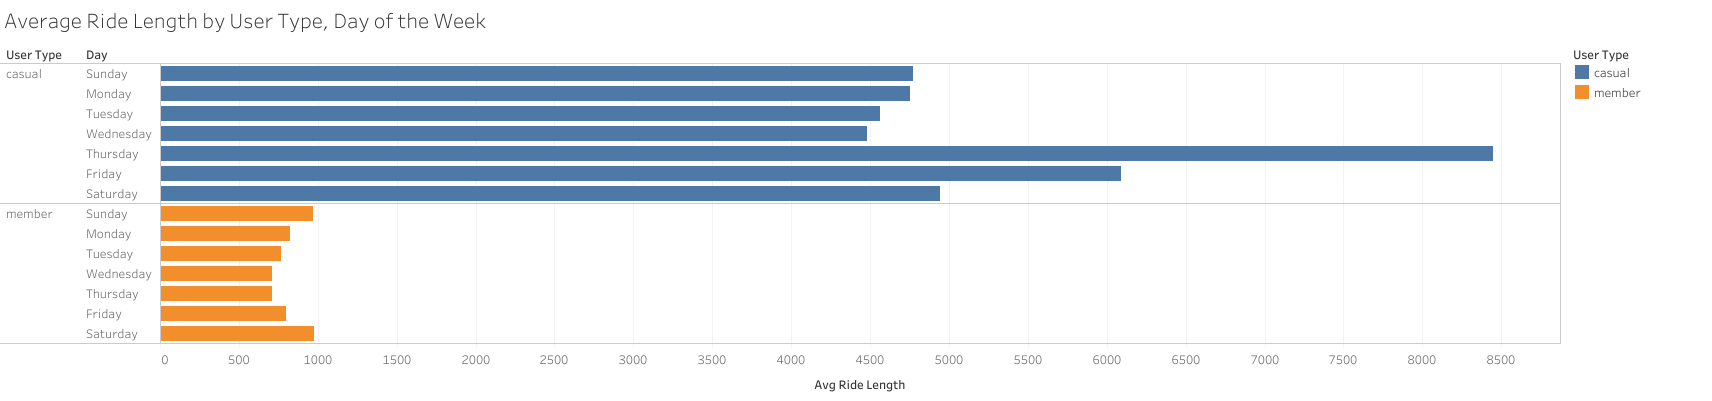

Despite the longer ride times, the number of rides taken by casual users is 100x less than the number of rides that member users take while using the service.

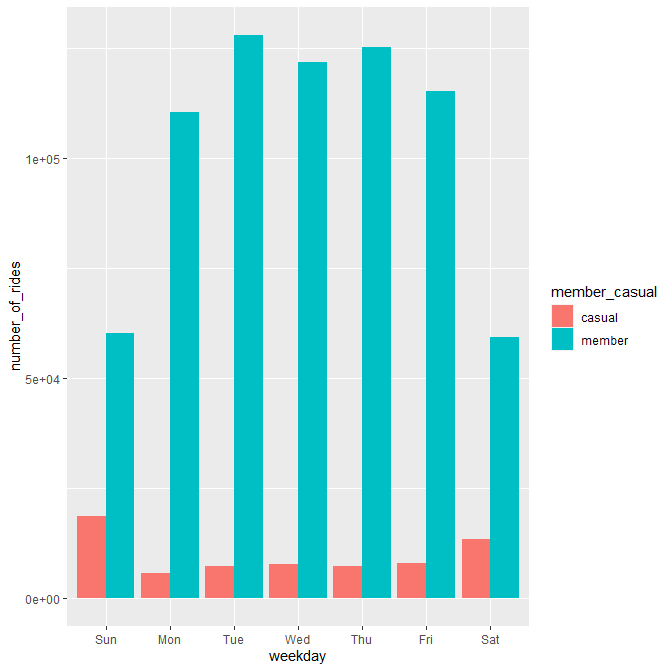

Based on the data and graphs above, it may not be worthwhile to attempt to convert casual users to members since they represent such a small number of the total rides taken. It may be worthwile to instead create additional subscritpion options such as a weekly or weekend subscritpion. Additional data about individual riders would be helpful as well to determine how much of each bar one user represents to better drive decisions about future bike hub installations and promotions and offers.